# 7. Global sensitivity analysis (simulator- and emulator- based)

In [2]:
import numpy as np
import torch

In [1]:
# import main libraries
from functools import partial

import numpy as np

from GPErks.constants import DEFAULT_RANDOM_SEED

# enforce reproducibility
from GPErks.utils.random import set_seed

seed = DEFAULT_RANDOM_SEED
set_seed(seed)

<br/>

Test function: **Sobol G*-function** - Saltelli, A. (2010) doi:10.1016/j.cpc.2009.09.018

<br/>

$G^*(x_1,\,\dots,\,x_D)=\prod_{i=1}^{D}g_i^*,\quad g_i^*=\dfrac{(1+\alpha_i)\cdot|2(x_i+\delta_i-I[x_i+\delta_i])-1|^{\alpha_i}+a_i}{1+a_i}$

<br/>


In [3]:
# import test function to run GSA
from GPErks.utils.test_functions_gsa import SobolGstar

d = 8  # SobolGstar parameter space is 8-dimensional
a = np.array([0, 1, 4.5, 9, 99, 99, 99, 99])
delta = np.random.rand(d)
alpha = np.ones_like(a)
f = partial(SobolGstar, a=a, delta=delta, alpha=alpha)
l_bounds, u_bounds = d * [0], d * [1]

In [4]:
# create dataset from function evaluations
from GPErks.gp.data.dataset import Dataset

dataset = Dataset.build_from_function(
    f,
    d,
    n_train_samples=160,
    n_val_samples=32,
    n_test_samples=80,
    design="lhs",
    seed=seed,
    l_bounds=l_bounds,
    u_bounds=u_bounds,
)
dataset.summary()


SobolGstar dataset loaded.
Notes from the author:
"This dataset was generated by using SobolGstar function evaluations."
Dataset properties:
-Input size: 8
-Input parameters: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']
-Output size: 1
-Output feature: ['y']
-Sample size: 160
-Discrepancy: 0.0107
-Validation data available: Yes (size = 32)
-Testing data available: Yes (size = 80)


In [5]:
# analytic solution
from GPErks.utils.test_functions_gsa import SobolGstar_theoretical_Si

df_STi, df_Si, _ = SobolGstar_theoretical_Si(a, delta, alpha)
print(df_STi)
print(df_Si)

         STi
X1  0.787144
X2  0.242198
X3  0.034317
X4  0.010460
X5  0.000105
X6  0.000105
X7  0.000105
X8  0.000105
          Si
X1  0.716192
X2  0.179048
X3  0.023676
X4  0.007162
X5  0.000072
X6  0.000072
X7  0.000072
X8  0.000072



<br/>

Herman, J. and Usher, W. (2017) **SALib: An open-source Python library for sensitivity analysis.** Journal of Open Source Software, 2(9). doi:10.21105/joss.00097

<br/>


In [6]:
# we use Saltelli method to numerically estimate Sobol' indices:
# main effects (Si) and total effects (STi)

# the example function chosen (SobolGstar) to perform GSA is computationally
# inexpensive, so we will directly pass it to the estimator method;
# a total of n x (2d + 2) function (model) evaluations will be performed
from GPErks.perks.gsa import SobolGSA

gsa = SobolGSA(dataset, n=1024, seed=seed)
gsa.estimate_Sobol_indices_with_simulator(f)
gsa.summary()

/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


                STi
Parameter          
X1         0.789275
X2         0.242931
X3         0.033832
X4         0.010783
X5         0.000104
X6         0.000115
X7         0.000107
X8         0.000107
                 Si
Parameter          
X1         0.718764
X2         0.174965
X3         0.021238
X4         0.007601
X5         0.000117
X6         0.000407
X7         0.000013
X8         0.000243


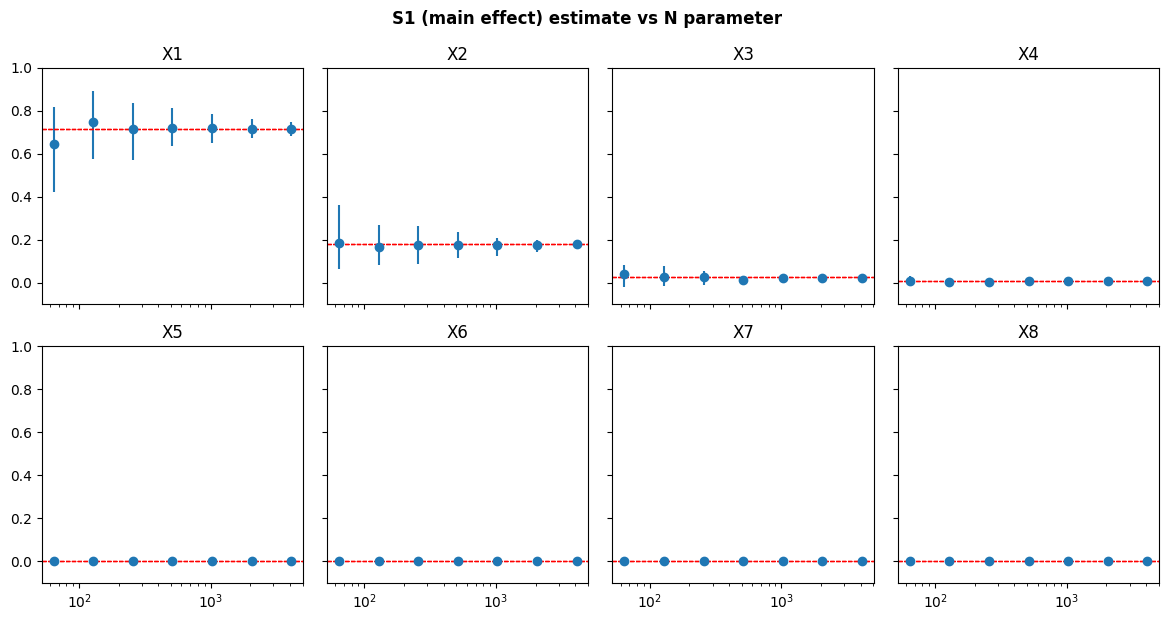

In [7]:
# here we repeat the same process by varying the baseline input sample value (n)
# to demonstrate that Sobol' indices estimates numerically converge to the true,
# theoretical values as n increases (note: chosen n value needs to be a power of 2)
import matplotlib.pyplot as plt

height = 9.36111
width = 5.91667
fig, axes = plt.subplots(
    2, 4, sharex=True, sharey=True, figsize=(2 * width, 2 * height / 3)
)
for i in range(6, 13):
    n_i = 2**i
    gsa = SobolGSA(dataset, n=n_i, seed=seed)
    gsa.estimate_Sobol_indices_with_simulator(f)
    for k, axis in enumerate(axes.flat):
        Si_k = gsa.S1[0, k]
        axis.errorbar(
            n_i,
            Si_k.reshape(-1, 1),
            yerr=np.array(
                [
                    Si_k - gsa.boot.first_order.confidence_interval.low[k],
                    gsa.boot.first_order.confidence_interval.high[k] - Si_k,
                ]
            ).reshape(-1, 1),
            fmt="o",
            color="C0",
        )
        axis.axhline(df_Si["Si"].iloc[k], c="r", ls="--", lw=0.8)
        axis.set_ylim([-0.1, 1])
        axis.set_title(f"X{k+1}")
fig.suptitle(
    "S1 (main effect) estimate vs N parameter", fontsize=12, fontweight="bold"
)
fig.tight_layout()
plt.xscale("log")
plt.show()

In [8]:
# let's estimate Sobol' indices using an emulator of the SobolGstar function

# define experiment
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from torchmetrics import MeanSquaredError, R2Score

from GPErks.gp.experiment import GPExperiment
from GPErks.gp.mean import LinearMean

likelihood = GaussianLikelihood()
mean_function = LinearMean(degree=1, input_size=dataset.input_size, bias=True)
kernel = ScaleKernel(MaternKernel(ard_num_dims=dataset.input_size))
metrics = [MeanSquaredError(), R2Score()]
experiment = GPExperiment(
    dataset,
    likelihood,
    mean_function,
    kernel,
    n_restarts=3,
    metrics=metrics,
    seed=seed,
)

In [9]:
# train emulator
import torch

from GPErks.train.early_stop import GLEarlyStoppingCriterion
from GPErks.train.emulator import GPEmulator

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
emulator = GPEmulator(experiment, device)
# emulator.train_auto()
optimizer = torch.optim.Adam(experiment.model.parameters(), lr=0.1)
esc = GLEarlyStoppingCriterion(max_epochs=1000, alpha=0.1, patience=8)
emulator.train(optimizer, early_stopping_criterion=esc)
emulator.hyperparameters()

INFO:2025-05-16 17:03:41,517:emulator:train:L82: Training emulator...
INFO:2025-05-16 17:03:41,517:emulator:train:L98: Running restart 1...
/Users/slongobardi/Projects/GPErks/.venv/lib/python3.12/site-packages/gpytorch/models/exact_gp.py:284: GPInputWarning: The input matches the stored training data. Did you forget to call model.train()?
  warnings.warn(
INFO:2025-05-16 17:03:41,552:emulator:_train_once:L303: [   1/1000] Training Loss: 1.8817 - MeanSquaredError: 0.1114 - R2Score: 0.8886 | Validation Loss: 1.4662 - MeanSquaredError: 0.9079 - R2Score: 0.1422
INFO:2025-05-16 17:03:41,561:emulator:_train_once:L303: [   2/1000] Training Loss: 1.6833 - MeanSquaredError: 0.1060 - R2Score: 0.8940 | Validation Loss: 1.2997 - MeanSquaredError: 0.7650 - R2Score: 0.2772
INFO:2025-05-16 17:03:41,573:emulator:_train_once:L303: [   3/1000] Training Loss: 1.5360 - MeanSquaredError: 0.1005 - R2Score: 0.8995 | Validation Loss: 1.1637 - MeanSquaredError: 0.6311 - R2Score: 0.4037
INFO:2025-05-16 17:03:41


Bias: -0.1874
Weights: tensor([-1.3382, -0.0322, -0.0733,  0.6656,  0.2573,  0.0336, -0.0610,  0.4889])
Outputscale: 1.0700
Lengthscales: tensor([0.3019, 0.5494, 2.1213, 1.3165, 2.4416, 4.7647, 6.2313, 2.1926])
Likelihood noise: 0.0098


In [ ]:
# check trained emulator accuracy
from GPErks.perks.inference import Inference

inference = Inference(emulator)
inference.summary()

In [10]:
# emulator-based gsa
from GPErks.perks.gsa import SobolGSA

gsa = SobolGSA(dataset, n=1024, seed=seed)
gsa.estimate_Sobol_indices_with_emulator(emulator, n_draws=1000)
gsa.correct_Sobol_indices(threshold=1e-2)
gsa.summary()

                STi
Parameter          
X1         0.799154
X2         0.240566
X3         0.032616
X4         0.038422
X5         0.020238
X6         0.014334
X7         0.012779
X8         0.024739
                 Si
Parameter          
X1         0.713136
X2         0.153108
X3         0.000000
X4         0.000000
X5         0.000000
X6         0.000000
X7         0.000000
X8         0.000000


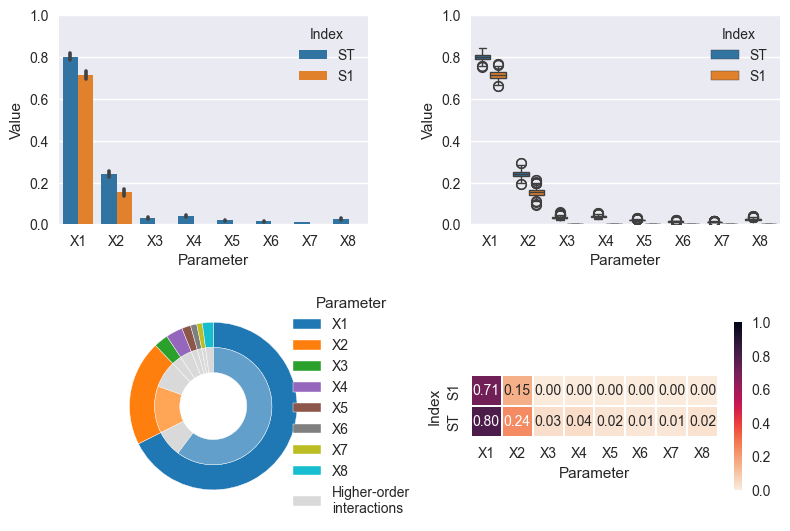

In [11]:
# plotting estimated sobol' indices

import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(2, 2)
gsa.plot(axis=axes[0, 0], type="bar", colors="tab10")
gsa.plot(axis=axes[0, 1], type="box", colors="tab10")
gsa.plot(axis=axes[1, 0], type="donut", colors="tab10")
gsa.plot(axis=axes[1, 1], type="heat", colors="rocket_r")
fig.tight_layout()
plt.show()